<a href="https://colab.research.google.com/github/jainmridul82/Encoder-Decoder-Architecture/blob/main/Encoder_Decoder_with_Dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import random
import re
from tqdm import tqdm_notebook
from xml.etree.ElementTree import parse
from torch.autograd import Variable
from torch.utils.data import Dataset
from IPython.display import clear_output

In [ ]:
device_gpu=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device_gpu)

cuda:0


In [ ]:
eng_alphabets='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char='-PAD-'
eng_alpha2index={pad_char:0}
for index,alpha in enumerate(eng_alphabets):
  eng_alpha2index[alpha]=index+1
print(eng_alpha2index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [ ]:
hindi_alphabets=[chr(alpha) for alpha in range(2304,2432)]
hindi_alphabets_size=len(hindi_alphabets)
hindi_alpha2index={pad_char:0}
for index,alpha in enumerate(hindi_alphabets):
  hindi_alpha2index[alpha]=index+1
print(hindi_alpha2index)

{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 

In [ ]:
non_eng_letters_regex=re.compile('[^a-z A-Z]')

In [ ]:
def cleanEnglishVocab(line):
  line=line.replace('-',' ').replace(',',' ').upper()
  line=non_eng_letters_regex.sub('',line)
  return line.split()

In [ ]:
cleanEnglishVocab('Make America Great Again!!!')

['MAKE', 'AMERICA', 'GREAT', 'AGAIN']

In [ ]:
def cleanHindiVocab(line):
  line=line.replace(',',' ').replace('-',' ')
  cleaned_line=''
  for char in line:
    if char in hindi_alpha2index or char==' ':
      cleaned_line+=char
  return cleaned_line.split()

In [ ]:
cleanHindiVocab('अमेरिका को फिर से महान बनाओ !!!')

['अमेरिका', 'को', 'फिर', 'से', 'महान', 'बनाओ']

In [ ]:
class Transliteration_Dataloader(Dataset):
  def __init__(self,filename):
    self.eng_words,self.hindi_words=self.readXmlDataset(filename)
    self.shuffle_start_index=0
    self.shuffle_indices=list(range(len(self.eng_words)))
    random.shuffle(self.shuffle_indices)
  def __len__(self):
    return len(self.eng_words)
  def __getitem__(self,idx):
    return self.eng_words[idx],self.hindi_words[idx]
  def readXmlDataset(self,filename):
    transliteration_corpus=parse(filename).getroot()
    lang1_list=[]
    lang2_list=[]
    for line in transliteration_corpus:
      batch1=cleanEnglishVocab(line[0].text)
      batch2=cleanHindiVocab(line[1].text)
      if len(batch1)!=len(batch2):
        print('Skipping: ',line[0].text,' - ',line[1].text)
        continue
      for data in batch1:
        lang1_list.append(data)
      for data in batch2:
        lang2_list.append(data)
    return lang1_list,lang2_list
  def get_sample_return(self):
    return self.__getitem__(np.random.randint(len(self.eng_words)))
  def get_batch_from_array(self,batch_size,array):
    batch=[]
    end=self.shuffle_start_index+batch_size
    if end>=len(self.eng_words):
      batch=[array[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
      end=len(self.eng_words)
    return batch+[array[i] for i in self.shuffle_indices[self.shuffle_start_index:end]]
  def get_batch(self,batch_size,post_process=True):
    batch1=self.get_batch_from_array(batch_size,self.eng_words)
    batch2=self.get_batch_from_array(batch_size,self.hindi_words)
    self.shuffle_start_index+=batch_size
    if self.shuffle_start_index>=len(self.eng_words):
      self.shuffle_start_index=0
      random.shuffle(self.shuffle_indices)
    return batch1,batch2

In [ ]:
train_data=Transliteration_Dataloader('/content/rI58TOlAScioEuPBbOYh_NEWS2012TrainingEnHi13937-1563719470862.xml')
test_data=Transliteration_Dataloader('/content/njThAK0RQGeoOuE9rfwg_NEWS2012RefEnHi1000-1563719263404.xml')

Skipping:  BARHARWA JUNCTION  -  बरहरवा
Skipping:  STATE BNK TR  -  स्टेट बैंक ऑफ त्रावणकोर
Skipping:  SOUTH ARLINGTON CHURCH OF CHRIST  -  साउथ अर्लिंग्टन
Skipping:  KING EDWARD VII  -  किंग एडवर्ड
Skipping:  DIBANG VALLEY  -  दिबंगवैली
Skipping:  ORDER OF VASA  -  ऑडर ऑफ़ द वासा
Skipping:  AZAMNAGAR ROAD  -  आज़मनगर
Skipping:  CAPE TOWN  -  केपटाउन
Skipping:  NEW ZEALAND  -  न्यूज़ीलैंड
Skipping:  SEA OF THE HEBRIDES  -  सी ऑफ हरब्रिड्‍स
Skipping:  RAMCOIND  -  राम्को इंड
Skipping:  KELVINGROVE ART GALLERY AND MUSEUM  -  केल्व‍िनग्रोव आर्ट एण्ड म्युज़ियम
Skipping:  AUSTRALIAN NATIONAL UNIVERSITY  -  ऑस्ट्रेलियननेशनल यूनिवर्सिटी
Skipping:  JAHAN AARA  -  जहाँआरा
Skipping:  NAVABHARAT FERRO ALLOYS  -  नव भारत फ़ैरो अलॉय
Skipping:  RAMA LINGESHWARA  -  रामालिंगेश्वर
Skipping:  FAKHRUN NISA  -  फखरुन्निसा
Skipping:  REDIFF.COM INDIA LIMITED  -  रेडिफ़ डॉट कॉम इंडिया लिमिटेड
Skipping:  OMKARNATH THAKUR  -  ओंकार नाथ ठाकुर
Skipping:  OPENTV  -  ओपन टीवी
Skipping:  ENVOY COMMUNICATIONS GROUP  

In [ ]:
def lang_rep(word,alpha2index,device='cpu'):
  rep=torch.zeros(len(word)+1,1,len(alpha2index)).to(device)
  for index,alpha in enumerate(word):
    pos=alpha2index[alpha]
    rep[index][0][pos]=1
  pad_pos=alpha2index[pad_char]
  rep[index+1][0][pad_pos]=1
  return rep

In [ ]:
def batched_word_rep(words,max_word_size,device='cpu'):
  rep = torch.zeros(max_word_size+1,len(words),len(eng_alpha2index)).to(device)
  for word_index,word in enumerate(words):
    for letter_index, letter in enumerate(word):
      pos=eng_alpha2index[letter]
      rep[letter_index][word_index][pos]=1
    pad_pos=eng_alpha2index[pad_char]
    rep[letter_index+1][word_index][pad_pos]=1
  return rep

In [ ]:
batched_word_rep(['PE', 'MEI'],3,device='cpu')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.,

In [ ]:
def batched_gt_rep(words,max_word_size,device='cpu'):
  rep = torch.zeros([max_word_size+1,len(words)],dtype=torch.long).to(device)
  for word_index,word in enumerate(words):
    for letter_index, letter in enumerate(word):
      rep[letter_index][word_index]=hindi_alpha2index[letter]
    rep[letter_index+1][word_index]=hindi_alpha2index[pad_char]
  return rep

In [ ]:
a=batched_gt_rep(['अमेरिका','भारत',],7)
print(a.shape)
print(a.view(-1))
print(a.shape)

torch.Size([8, 2])
tensor([ 6, 46, 47, 63, 72, 49, 49, 37, 64,  0, 22,  0, 63,  0,  0,  0])
torch.Size([8, 2])


In [ ]:
def batched_dataloader(npoints,X_,Y_,verbose=False,device='cpu'):
  words=[]
  gts=[]
  X_lengths=[]
  Y_lengths=[]

  for i in range(npoints):
    word,gt=X_[i],Y_[i]

    X_lengths.append(len(word))
    Y_lengths.append(len(gt))

    words.append(word)
    gts.append(gt)

  max_length_X=max(X_lengths)
  max_length_Y=max(Y_lengths)

  words_rep=batched_word_rep(words,max_length_X,device)
  gts_rep=batched_gt_rep(gts,max_length_Y,device)

  padded_words_rep=torch.nn.utils.rnn.pack_padded_sequence(words_rep,X_lengths,enforce_sorted=False)
  padded_gts_rep=torch.nn.utils.rnn.pack_padded_sequence(gts_rep,Y_lengths,enforce_sorted=False)

  if verbose:
    print(words_rep.shape, padded_words_rep.data.shape)
    print(gts_rep.shape,padded_gts_rep.data.shape)
    print('--')

  if verbose:
    print(words)
    print(gts)
    print_char(words_rep)
    print_char(padded_words_rep.data)
    print('---')
    print_char_gts(gts_rep)
    print('-same-')
    print_char_gts(padded_gts_rep.data)
    print('--')

  if verbose:
    print('Padded words rep',padded_words_rep.data)
    print('Padded words batch sizes', padded_words_rep.batch_sizes)
    print('--')
    print('Padded gt rep',padded_gts_rep.data)
    print('Padded gt batch sizes', padded_gts_rep.batch_sizes)

  return padded_words_rep,padded_gts_rep

In [ ]:
def print_char(name_reps):
    name_reps = name_reps.view((-1, name_reps.size()[-1]))
    for t in name_reps:
        if torch.sum(t) == 0:
            print('<pad>')
        else:
            index = t.argmax()
            print(list(eng_alpha2index.keys())[index])

In [ ]:
def print_char_gts(name_reps):
    name_reps = name_reps.view(-1)
    for t in name_reps:
        if t.item() == 0:
            print('<pad>')
        else:
            print(list(hindi_alpha2index.keys())[t])

In [ ]:
a,b=batched_dataloader(2,test_data.eng_words,test_data.hindi_words,True)

torch.Size([7, 2, 27]) torch.Size([11, 27])
torch.Size([5, 2]) torch.Size([7])
--
['AADHI', 'AAKASH']
['आधी', 'आकाश']
A
A
A
A
D
K
H
A
I
S
-PAD-
H
<pad>
-PAD-
A
A
A
A
K
D
A
H
S
I
H
---
आ
आ
ध
क
ी
ा
<pad>
श
<pad>
<pad>
-same-
आ
आ
क
ध
ा
ी
श
--
Padded words rep tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.

In [ ]:
lang_rep('AMERICA',eng_alpha2index)

tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
     

In [ ]:
def gt_rep(word,alpha2index,device='cpu'):
  rep=torch.zeros([len(word)+1,1],dtype=torch.long).to(device)
  for index,alpha in enumerate(word):
    rep[index][0]=alpha2index[alpha]
  rep[index+1][0]=alpha2index[pad_char]
  return rep

In [ ]:
gt_rep('अमेरिका',hindi_alpha2index).shape

torch.Size([8, 1])

In [ ]:
class Transliteration_EncoderDecoder(torch.nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(Transliteration_EncoderDecoder,self).__init__()
    self.hidden_size=hidden_size
    self.output_size=output_size
    self.softmax=torch.nn.LogSoftmax(dim=2)
    self.h2o=torch.nn.Linear(hidden_size,output_size)
    self.encoder_rnn_cell=torch.nn.GRU(input_size,hidden_size)
    self.decoder_rnn_cell=torch.nn.GRU(output_size,hidden_size)
  def forward(self,input_,max_output_chars,device='cpu',gt=None):
    out,hidden=self.encoder_rnn_cell(input_)
    decoder_state=hidden
    decoder_input=torch.zeros(1,1,self.output_size).to(device)
    outputs=[]
    for i in range(max_output_chars):
      out,decoder_state=self.decoder_rnn_cell(decoder_input)
      out=self.h2o(decoder_state)
      out=self.softmax(out)
      outputs.append(out.view(1,-1))
      max_idx=torch.argmax(out,2,keepdim=True)
      if not gt is None:
        max_idx=gt[i].reshape(1,1,1)
      one_hot=torch.FloatTensor(out.shape).to(device)
      one_hot.zero_()
      one_hot.scatter_(2,max_idx,1)
      decoder_input=one_hot.detach()
    return outputs

In [ ]:
def infer(net,input_,max_output_chars,device='cpu'):
  net=net.to(device)
  input_=lang_rep(input_,eng_alpha2index,device)
  output=net(input_,max_output_chars,device,None)
  return output

In [ ]:
eng,hindi=batched_dataloader(10,train_data.eng_words,train_data.hindi_words,verbose=False)
print(eng.data.shape,hindi.data.shape)

torch.Size([69, 27]) torch.Size([59])


In [ ]:
def train_batch(net,opt,criterion,batch_size,device='cpu',teacher_force=False):
  net=net.train().to(device)
  opt.zero_grad()
  total_loss=0
  eng,hindi=train_data.get_batch(batch_size)
  eng,hindi=batched_dataloader(batch_size,eng,hindi,verbose=False,device=device)
  hindi=hindi.data
  hindi.resize_((hindi.size()[-1],1))
  outputs=net(eng,hindi.shape[0],device,hindi if teacher_force else None)
  for index,output in enumerate(outputs):
    loss=criterion(output,hindi[index])/batch_size
    loss.backward(retain_graph=True)
    total_loss+=loss
  opt.step()
  return total_loss/batch_size

In [ ]:
def train_setup(net,lr,momentum,n_batches,batch_size,display_freq,device='cpu'):
  net=net.train().to(device)
  opt=torch.optim.Adam(net.parameters(),lr=lr)
  criterion=torch.nn.NLLLoss(ignore_index=-1)
  loss_arr=np.zeros(n_batches+1)
  #teacher_force_upto=n_batches//3
  for i in range(n_batches):
    loss_arr[i+1]=(loss_arr[i]*i+train_batch(net,opt,criterion,batch_size,device,True))/(i+1)
    if i%display_freq==display_freq-1:
      clear_output(wait=True)
      print('Iteration',i,'Loss',loss_arr[i])
      plt.figure()
      plt.plot(loss_arr[1:i],'-*')
      plt.xlabel('Iteration')
      plt.ylabel('Loss')
      plt.show()
  torch.save(net,'model_full_teacher_force_padding.pt')
  return loss_arr

Iteration 989 Loss 0.30884259939193726


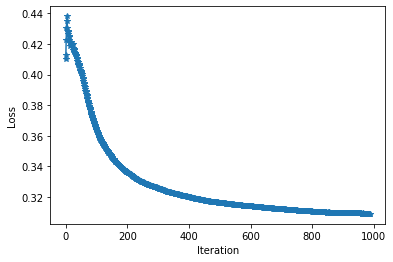

In [ ]:
net=Transliteration_EncoderDecoder(len(eng_alpha2index),128,len(hindi_alpha2index))
train_setup(net,lr=0.001,momentum=0.9,n_batches=2048,batch_size=64,display_freq=5,device=device_gpu)

In [ ]:
def test(net,word,max_output_chars,device='cpu'):
  net=net.eval().to(device)
  hindi_output=''
  outputs=infer(net,word,max_output_chars,device)
  for out in outputs:
    _,indices=out.topk(1)
    index=indices.tolist()[0][0]
    if index==0:
      break
    hindi_char=hindi_alphabets[index-1]
    hindi_output+=hindi_char
  print(word,' - ',hindi_output)
  return hindi_output

In [ ]:
test(net,'BD',10,device_gpu)

BD  -  रररररररररर


'रररररररररर'

In [ ]:
def get_accuracy(net,device='cpu'):
  net=net.eval().to(device)
  accuracy=0
  for i in range(len(test_data)):
    eng,hindi=test_data[i]
    gt=gt_rep(hindi,hindi_alpha2index,device)
    outputs=infer(net,eng,gt.shape[0],device)
    correct=0
    for index,output in enumerate(outputs):
      vals,indices=output.topk(1)
      indices=indices.tolist()[0]
      if indices[0]==gt[index][0]:
        correct+=1
    accuracy+=correct/gt.shape[0]
  accuracy/=len(test_data)
  return accuracy

In [ ]:
get_accuracy(net,device_gpu)

0.06313122433122459